In [1]:
import numpy as np
import os
from tqdm import tqdm
import fish_track as ft
import fish_corr as fc
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.cluster import KMeans
from skvideo.io import vread
from scipy.spatial.distance import cdist, squareform, pdist
from scipy import ndimage
from scipy.optimize import curve_fit, least_squares
from scipy.spatial.transform import Rotation as R
import yaggie
import pickle
from matplotlib.image import NonUniformImage

%load_ext autoreload
%autoreload 2

# Read Data

In [2]:
with open('trajectories_50_small.pkl', 'rb') as f:
    trajectories = pickle.load(f)
blur = None

fish_trajs = []

for traj in trajectories:
    xyz = np.array(traj['position']).T
    xyz = ndimage.gaussian_filter1d(xyz, 1, axis=1)
    t = np.array(traj['time'])
    ti = np.arange(t[0], t[-1]+1, 1)
    xi = np.interp(x = ti, xp = t, fp = xyz[0])
    yi = np.interp(x = ti, xp = t, fp = xyz[1])
    zi = np.interp(x = ti, xp = t, fp = xyz[2])
    xyz_int = np.vstack((xi, yi, zi))
    T = ft.Trajectory(ti, xyz_int.T, blur)
    fish_trajs.append(T)
    
manager = ft.Manager(fish_trajs)

print(manager)

trajectory manager: 1281 trajectories


# Visualising Group Centres

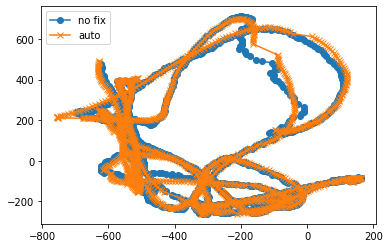

In [3]:
gce_1 = fc.utility.GCE(manager.trajs)
gce_3 = fc.utility.GCE(manager.trajs, 48)
plt.plot(*gce_1.centres.T[:2], '-o', label='no fix')
plt.plot(*gce_3.centres.T[:2], '-x', label='auto')
plt.legend()
plt.show()

# Ordered Movements

In [6]:
dyn_o = fc.order.DynamicalOrder(manager.trajs)
t_orders, r_orders, d_orders = dyn_o.get_orders()

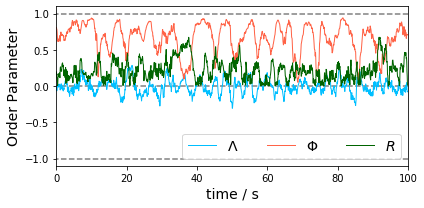

In [21]:
x = np.arange(-1, len(d_orders), 1)
y1 = np.ones(x.shape) * -1
y2 = np.ones(x.shape) * 0
y3 = np.ones(x.shape) * 1
plt.plot(x, y1, '--', color='k', alpha=0.5)
plt.plot(x, y2, '--', color='k', alpha=0.5)
plt.plot(x, y3, '--', color='k', alpha=0.5)

plt.plot(np.arange(len(d_orders))/15, d_orders, label=r'$\Lambda$',
         color='deepskyblue', linewidth=1)
plt.plot(np.arange(len(t_orders))/15, np.abs(t_orders), label=r'$\Phi$',
            color='tomato', linewidth=1)
plt.plot(np.arange(len(r_orders))/15, np.abs(r_orders), label=r'$R$',
         color='darkgreen', linewidth=1)

plt.legend(fontsize=14, loc='lower right', ncol=3)
plt.ylim(-1.1, 1.1)
plt.xlim(0, 100)
plt.xlabel('time / s', fontsize=14)
plt.ylabel(f'Order Parameter', fontsize=14)
plt.gcf().set_size_inches(6, 3)
plt.tight_layout()
plt.savefig('order_par_small.pdf')
plt.show()

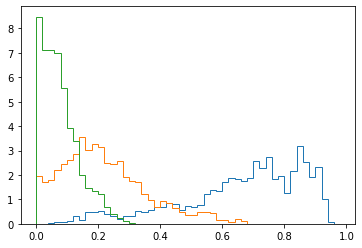

In [8]:
plt.hist(t_orders, histtype='step', bins=np.arange(0, 1, 0.02), density=True)
plt.hist(np.abs(r_orders), histtype='step', bins=np.arange(0, 1, 0.02), density=True)
plt.hist(np.abs(d_orders), histtype='step', bins=np.arange(0, 1, 0.02), density=True)
plt.show()

# Convex Hull of the group

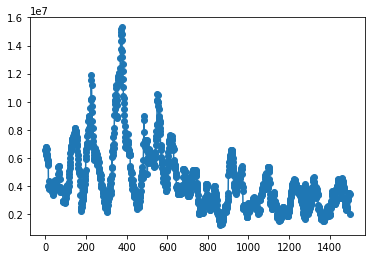

In [9]:
ch_volumes = []
for ch in fc.utility.get_convex_hull(manager.trajs, 1):
    v = ch.volume
    ch_volumes.append(v)
    
plt.plot(ch_volumes, '-o')
plt.show()

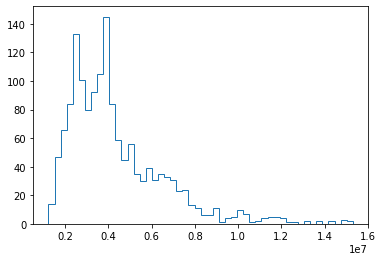

In [10]:
plt.hist(ch_volumes, bins=50, histtype='step')
plt.show()

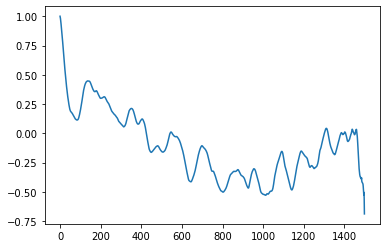

In [11]:
acf_chv, _ = fc.utility.get_acf(ch_volumes)
plt.plot(acf_chv)

# Radius of Gyration

Effective diameter is 69.95±12.46


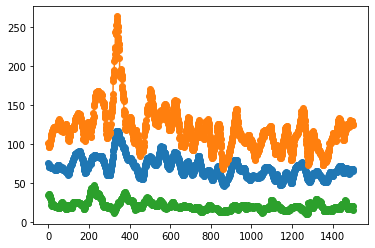

In [12]:
radii = []
r_max, r_min = [], []
for S in fc.utility.get_rg_tensor(manager.trajs, 20):
    eig = np.sqrt(np.linalg.eigvals(S))
    r_max.append(np.max(eig))
    r_min.append(np.min(eig))
    radii.append(np.mean(eig))
plt.plot(radii, '-o')
plt.plot(r_max, '-o')
plt.plot(r_min, '-o')
print(f"Effective diameter is {np.mean(radii):.2f}±{np.std(radii):.2f}")

# ACF of Order

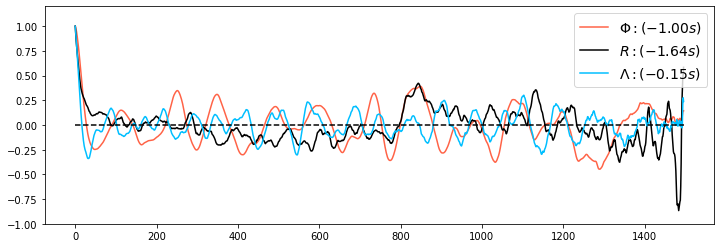

In [16]:
acf_trans, std_trans = fc.utility.get_acf(t_orders)
acf_rot, std_rot = fc.utility.get_acf(np.abs(r_orders))
acf_dila, std_dila = fc.utility.get_acf(d_orders)
    
tao_trans = np.trapz(acf_trans, np.arange(len(acf_trans))/15)
tao_rot = np.trapz(acf_rot, np.arange(len(acf_rot))/15)
tao_dila = np.trapz(acf_dila, np.arange(len(acf_dila))/15)

plt.subplot(111).plot(acf_trans, color='tomato', label=fr'$\Phi: ({tao_trans:.2f} s)$')
plt.gca().plot(acf_rot, color='k', label=fr'$R: ({tao_rot:.2f} s)$')
plt.gca().plot(acf_dila, color='deepskyblue', label=fr'$\Lambda: ({tao_dila:.2f} s)$')
plt.gca().plot([0, len(acf_trans)], [0, 0], '--', color='k')

plt.ylim(-1, 1.2)

plt.gcf().set_size_inches(12, 4)
plt.legend(fontsize=14)
plt.savefig('order_acf_small.pdf')
plt.show()

# Velocity Correlations

In [3]:
bins = np.linspace(0, 500, 26)
my_corr = fc.correlation.my_cvv(manager.trajs, bins, range(500))

KeyboardInterrupt: 

In [ ]:
mm_to_body = 20

fish_sizes = np.array([np.count_nonzero(~np.isnan(c)) for c in my_corr])

plt.errorbar(bins[:-1] / mm_to_body, np.nanmean(my_corr, 1),
             np.nanstd(my_corr, 1) / np.sqrt(fish_sizes),
             color='k', capsize=3, zorder=0)

plt.scatter(bins[:-1] / mm_to_body, np.nanmean(my_corr, 1),
            color='tomato', edgecolor='k', label='Fish')

plt.plot([-10, 40], [0, 0], color='k', linewidth=1)
plt.xlim(-1, 40)
plt.ylim(-0.3, 0.3)
plt.ylabel('C(r)', fontsize=14)
plt.xlabel('r (body length)', fontsize=14)
plt.gcf().set_size_inches(6, 2)
plt.savefig('my_cvv_small.pdf')
plt.show()

In [5]:
bins = np.linspace(0, 500, 26)
corr = fc.correlation.cavagna_cvv(manager.trajs, bins, range(500))

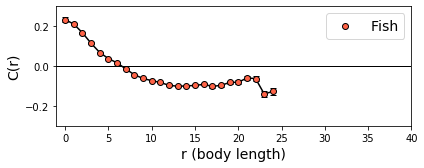

In [6]:
mm_to_bl = 20
frame_to_s = 1/30

fish_sizes = np.array([np.count_nonzero(~np.isnan(c)) for c in corr])

plt.errorbar(bins[:-1] / mm_to_bl, np.nanmean(corr, 1),
             np.nanstd(corr, 1) / np.sqrt(fish_sizes),
             color='k', capsize=3, zorder=0)

plt.scatter(bins[:-1] / mm_to_bl, np.nanmean(corr, 1),
            color='tomato', edgecolor='k', label='Fish')

plt.plot([-10, 500], [0, 0], color='k', linewidth=1)
plt.xlim(-1, 40)
plt.ylim(-0.3, 0.3)
plt.ylabel('C(r)', fontsize=14)
plt.xlabel('r (body length)', fontsize=14)
plt.legend(fontsize=14, loc='upper right')
plt.gcf().set_size_inches(6, 2.5)
plt.tight_layout()
plt.savefig('cvv_small.pdf')
plt.show()

In [11]:
corr_x = bins[:-1]/mm_to_bl
corr_y = np.nanmean(corr, 1)
corr_y_err = np.nanstd(corr, 1) / np.sqrt(fish_sizes)
np.save("corr_small", np.vstack((corr_x, corr_y, corr_y_err)))

# Where are the fish?

In [3]:
with open('tank_50_small.pkl', 'rb') as f:
    tank = pickle.load(f)

In [5]:
movie = ft.Movie(trajectories)
distances = []
radii = []
angles = []
X, Y, Z = [], [], []
for i, frame in enumerate(movie):
    if i % 5 != 0:
        continue
    xyz = tank.get_xyz(frame)
    #xyz = frame.T
    X.append(xyz[0])
    Y.append(xyz[1])
    Z.append(xyz[2])
    curvilinear = tank.get_curvilinear(frame)
    radius, theta, distance = curvilinear
    distances.append(distance)
    radii.append(radius)
    angles.append(theta)
    if i == 1495:
        break

distances = np.concatenate(distances)
radii = np.concatenate(radii)
angles = np.concatenate(angles)
X = np.concatenate(X)
Y = np.concatenate(Y)
Z = np.concatenate(Z)

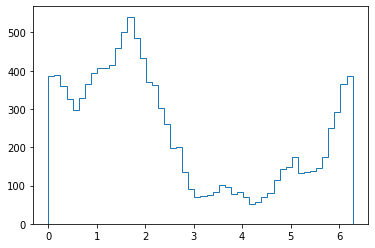

In [6]:
plt.hist(angles, histtype='step', bins=50)
plt.show()

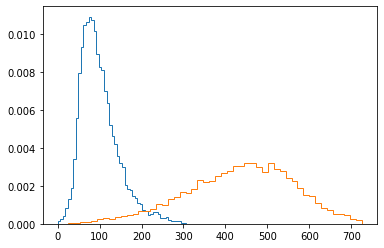

In [7]:
plt.hist(distances, histtype='step', bins=50, density=True)
plt.hist(radii, histtype='step', bins=50, density=True)
plt.show()

In [7]:
np.save('distances_small', distances)
np.save('radii_small', radii)

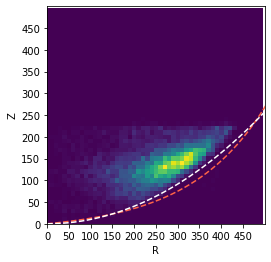

In [16]:
hist_2d, x_edges, y_edges  = np.histogram2d(
    np.sqrt(X**2 + Y**2), Z, bins=(50, 50), range=((0, 700), (0, 700)),
    density=True
)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(hist_2d.T, vmin=0, vmax=5e-5)
ax.set_ylim(0, 50)
ax.set_xticks(range(0, 50, 5))
ax.set_xticklabels(range(0, 700, 50))
ax.set_yticks(range(0, 50, 5))
ax.set_yticklabels(range(0, 700, 50))
ax.set_xlabel("R")
ax.set_ylabel("Z")
r = np.arange(1000)
ax.plot(r/700*50, tank.z(r)/700*50, color='tomato', ls='--')
ax.plot(r/700*50, (7.1901e-04 * r**2 + 3.2205e-11 * r**4)/700*50, color='w', ls='--')
ax.set_xlim(0, 50)
plt.show()

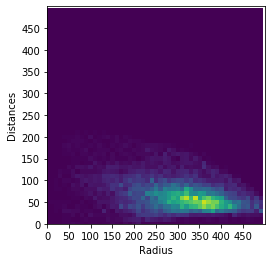

In [16]:
hist_2d, x_edges, y_edges  = np.histogram2d(
    radii, distances, bins=(50, 50), range=((0, 700), (0, 700)),
    density=True
)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(hist_2d.T, vmin=0, vmax=5e-5)
ax.set_ylim(0, 50)
ax.set_xticks(range(0, 50, 5))
ax.set_xticklabels(range(0, 700, 50))
ax.set_yticks(range(0, 50, 5))
ax.set_yticklabels(range(0, 700, 50))
ax.set_xlabel("Radius")
ax.set_ylabel("Distances")
#ax.plot(np.arange(700) / 700 * 50, tank.z(np.arange(700)) / 700 * 50, color='tomato', ls='--')
ax.set_xlim(0, 50)
plt.show()